In [1]:
### ------------------------------- ###
### MovieLens Analysis ###
### Author: Asim Jamal ###
### Dataset link : https://files.grouplens.org/datasets/movielens/ml-100k.zip ###
### ------------------------------- ###

In [2]:
#Installing Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode
import plotly.express as px
import re
import os

In [3]:
# ------------------------------
# Load Data
# ------------------------------
# u.data: user_id, item_id, rating, timestamp
ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])

# u.item: movie_id | title | release_date | video_release | imdb_url | genres...
movies = pd.read_csv("ml-100k/u.item", sep="|", encoding="latin-1", header=None)
movies = movies.iloc[:, :24]  # first 24 cols only
movies.columns = ["movie_id", "title", "release_date", "video_release", "imdb_url"] + [f"genre_{i}" for i in range(19)]

In [4]:
# Merge ratings with movie info
data = ratings.merge(movies[["movie_id", "title", "release_date"]], on="movie_id")

# Convert release_date to year
data["year"] = pd.to_datetime(data["release_date"], errors="coerce").dt.year

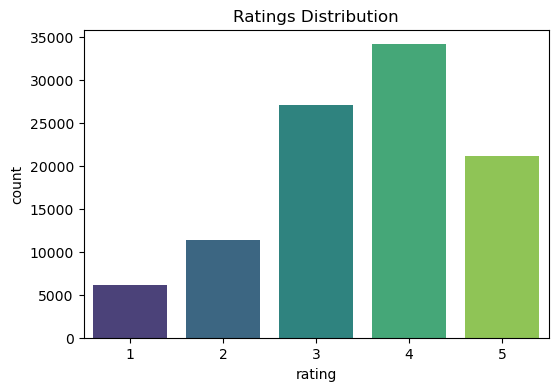

In [5]:
# ------------------------------
# 1. Rating distribution
# ------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=data, palette="viridis")
plt.title("Ratings Distribution")
plt.show()

In [6]:
# ------------------------------
# 2. Top/Bottom 10 movies by avg rating (min 50 ratings)
# ------------------------------
movie_stats = data.groupby("title").agg(
    avg_rating=("rating","mean"),
    n_ratings=("rating","count")
).reset_index()
filtered = movie_stats[movie_stats["n_ratings"] >= 50]

top10 = filtered.sort_values("avg_rating", ascending=False).head(10)
bottom10 = filtered.sort_values("avg_rating", ascending=True).head(10)

print("Top 10 Movies by Average Rating:\n", top10)
print("\nBottom 10 Movies by Average Rating:\n", bottom10)

Top 10 Movies by Average Rating:
                                                   title  avg_rating  n_ratings
318                               Close Shave, A (1995)    4.491071        112
1281                            Schindler's List (1993)    4.466443        298
1652                         Wrong Trousers, The (1993)    4.466102        118
273                                   Casablanca (1942)    4.456790        243
1597  Wallace & Gromit: The Best of Aardman Animatio...    4.447761         67
1317                   Shawshank Redemption, The (1994)    4.445230        283
1215                                 Rear Window (1954)    4.387560        209
1572                         Usual Suspects, The (1995)    4.385768        267
1398                                   Star Wars (1977)    4.358491        583
3                                   12 Angry Men (1957)    4.344000        125

Bottom 10 Movies by Average Rating:
                                        title  avg_rating  n


Top 10 Most Rated Movies:
                               title  avg_rating  n_ratings
1398               Star Wars (1977)    4.358491        583
333                  Contact (1997)    3.803536        509
498                    Fargo (1996)    4.155512        508
1234      Return of the Jedi (1983)    4.007890        507
860                Liar Liar (1997)    3.156701        485
460     English Patient, The (1996)    3.656965        481
1284                  Scream (1996)    3.441423        478
1523               Toy Story (1995)    3.878319        452
32             Air Force One (1997)    3.631090        431
744   Independence Day (ID4) (1996)    3.438228        429


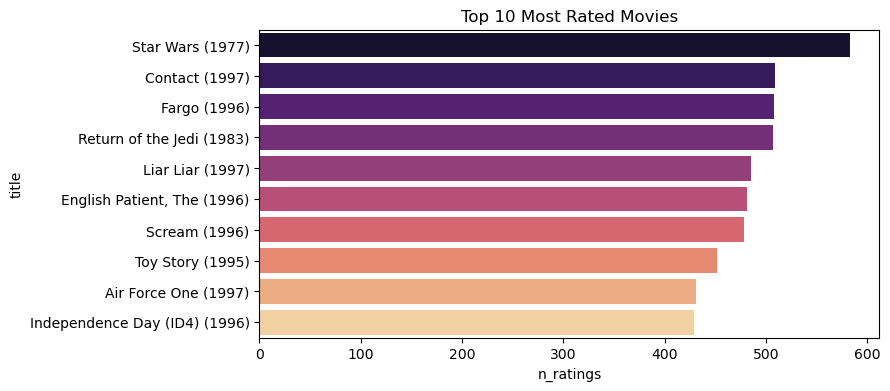

In [7]:
# ------------------------------
# 3. Top 10 most rated movies
# ------------------------------
most_rated = movie_stats.sort_values("n_ratings", ascending=False).head(10)
print("\nTop 10 Most Rated Movies:\n", most_rated)

plt.figure(figsize=(8,4))
sns.barplot(x="n_ratings", y="title", data=most_rated, palette="magma")
plt.title("Top 10 Most Rated Movies")
plt.show()


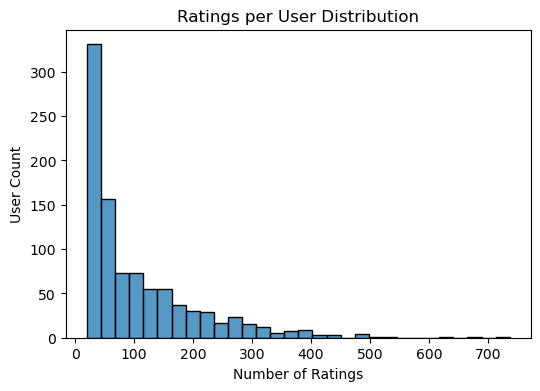

In [8]:
# ------------------------------
# 4. Ratings per user distribution
# ------------------------------
user_activity = data.groupby("user_id")["rating"].count()

plt.figure(figsize=(6,4))
sns.histplot(user_activity, bins=30, kde=False)
plt.title("Ratings per User Distribution")
plt.xlabel("Number of Ratings")
plt.ylabel("User Count")
plt.show()

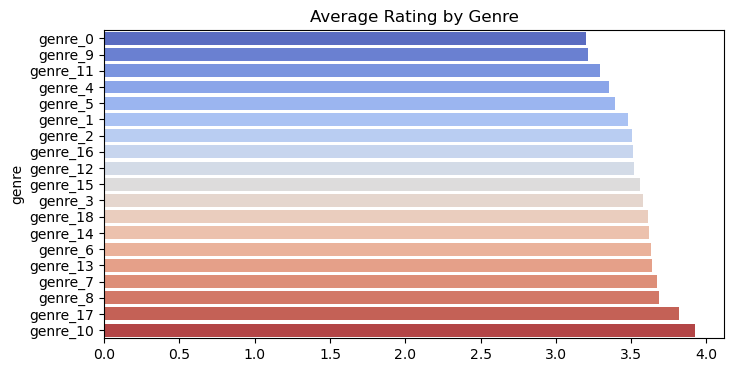

In [9]:
# ------------------------------
# 5. Avg rating by genre
# ------------------------------
# Extract genre columns
genre_cols = [c for c in movies.columns if "genre_" in c]
movie_genres = movies[["movie_id"] + genre_cols]

# Merge with ratings
genre_data = ratings.merge(movie_genres, on="movie_id")

# Melt to long format
genre_melt = genre_data.melt(
    id_vars=["rating"], 
    value_vars=genre_cols, 
    var_name="genre", 
    value_name="is_genre"
)

# Filter only rows where genre applies
genre_melt = genre_melt[genre_melt["is_genre"] == 1]

avg_rating_genre = genre_melt.groupby("genre")["rating"].mean().sort_values()

plt.figure(figsize=(8,4))
sns.barplot(x=avg_rating_genre.values, y=avg_rating_genre.index, palette="coolwarm")
plt.title("Average Rating by Genre")
plt.show()

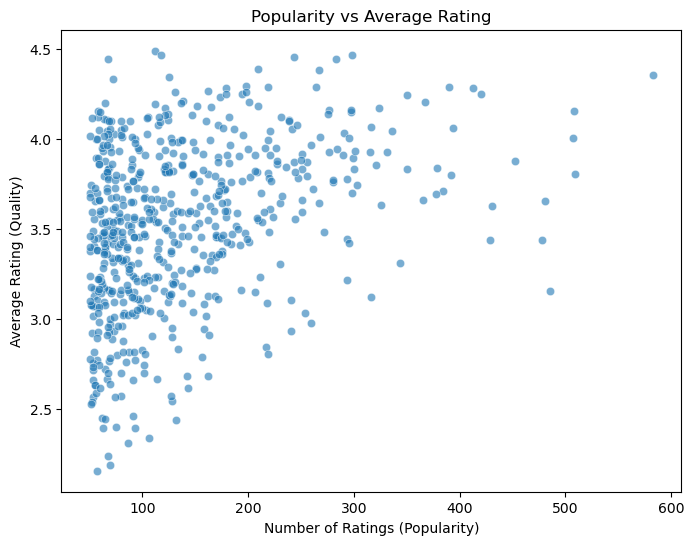

In [10]:
# ------------------------------
# 6. Popularity vs Quality scatterplot
# ------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x="n_ratings", y="avg_rating", data=filtered, alpha=0.6)
plt.title("Popularity vs Average Rating")
plt.xlabel("Number of Ratings (Popularity)")
plt.ylabel("Average Rating (Quality)")
plt.show()

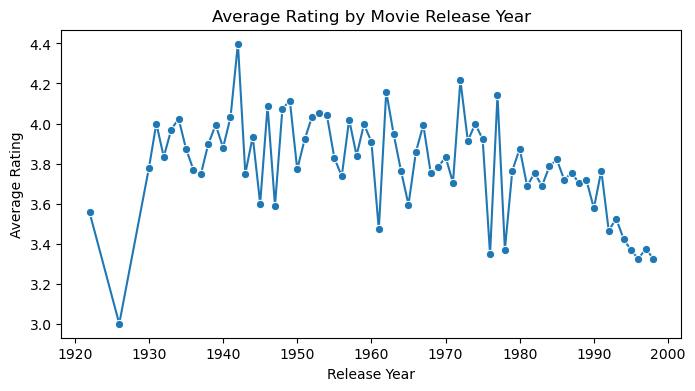

In [11]:
# ------------------------------
# 7. Average rating trend over release year
# ------------------------------
yearly = data.groupby("year")["rating"].mean().dropna()

plt.figure(figsize=(8,4))
sns.lineplot(x=yearly.index, y=yearly.values, marker="o")
plt.title("Average Rating by Movie Release Year")
plt.xlabel("Release Year")
plt.ylabel("Average Rating")
plt.show()

### User Behavior & Demographics

In [12]:
# User demographics
users = pd.read_csv("ml-100k/u.user", sep="|", names=["user_id","age","gender","occupation","zip_code"])

# Merge ratings with user demographics
data = ratings.merge(users, on="user_id")

#### User Bias Analysis

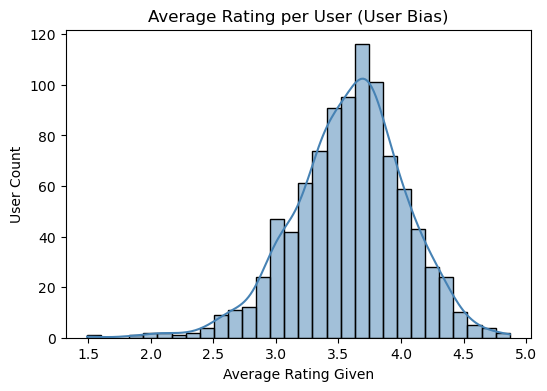

In [13]:
user_bias = data.groupby("user_id")["rating"].mean().reset_index()
plt.figure(figsize=(6,4))
sns.histplot(user_bias["rating"], bins=30, kde=True, color="steelblue")
plt.title("Average Rating per User (User Bias)")
plt.xlabel("Average Rating Given")
plt.ylabel("User Count")
plt.show()

#### Gender-Based Analysis

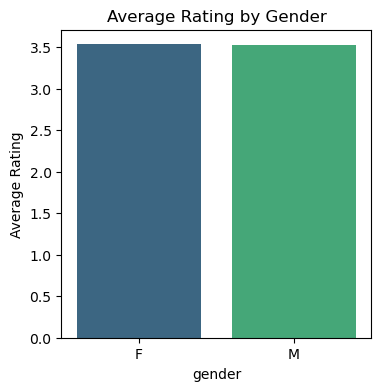

  gender    rating
0      F  3.531507
1      M  3.529289


In [14]:
gender_avg = data.groupby("gender")["rating"].mean().reset_index()

plt.figure(figsize=(4,4))
sns.barplot(x="gender", y="rating", data=gender_avg, palette="viridis")
plt.title("Average Rating by Gender")
plt.ylabel("Average Rating")
plt.show()

print(gender_avg)

#### Age Group Analysis

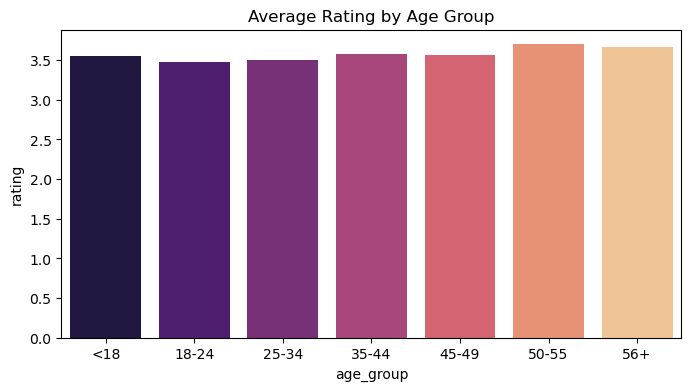

  age_group    rating
0       <18  3.552229
1     18-24  3.470565
2     25-34  3.497959
3     35-44  3.575259
4     45-49  3.567870
5     50-55  3.698416
6       56+  3.665577


In [15]:
bins = [0, 18, 25, 35, 45, 50, 56, 100]
labels = ["<18","18-24","25-34","35-44","45-49","50-55","56+"]
users["age_group"] = pd.cut(users["age"], bins=bins, labels=labels)

data = data.merge(users[["user_id","age_group"]], on="user_id")

age_avg = data.groupby("age_group")["rating"].mean().reset_index()

plt.figure(figsize=(8,4))
sns.barplot(x="age_group", y="rating", data=age_avg, palette="magma")
plt.title("Average Rating by Age Group")
plt.show()

print(age_avg)

#### Occupation-Based Analysis

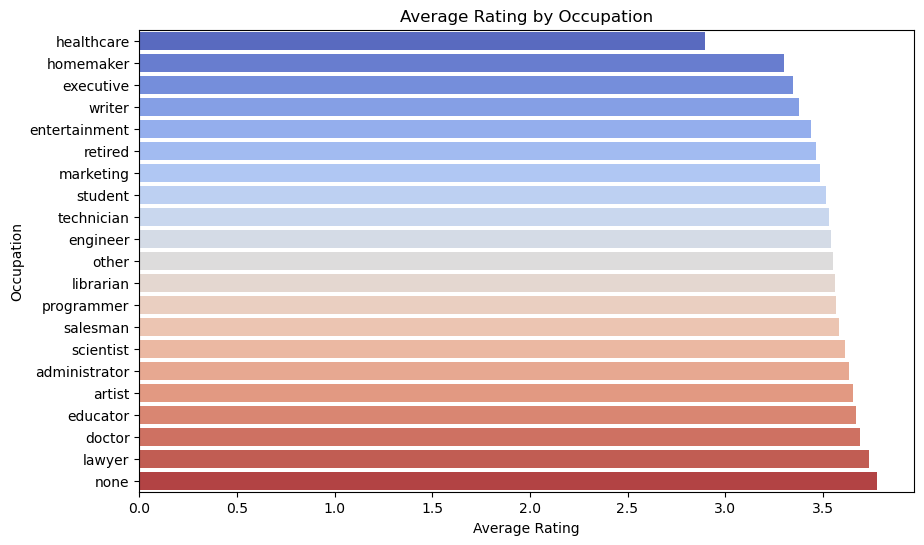

       occupation    rating
0      healthcare  2.896220
1       homemaker  3.301003
2       executive  3.349104
3          writer  3.375723
4   entertainment  3.441050
5         retired  3.466750
6       marketing  3.485641
7         student  3.515143
8      technician  3.532230
9        engineer  3.541407
10          other  3.552377
11      librarian  3.560781
12     programmer  3.568260
13       salesman  3.582944
14      scientist  3.611273
15  administrator  3.635646
16         artist  3.653380
17       educator  3.670621
18         doctor  3.688889
19         lawyer  3.735316
20           none  3.779134


In [16]:
occ_avg = data.groupby("occupation")["rating"].mean().sort_values().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x="rating", y="occupation", data=occ_avg, palette="coolwarm")
plt.title("Average Rating by Occupation")
plt.xlabel("Average Rating")
plt.ylabel("Occupation")
plt.show()

print(occ_avg)

#### Polarizing Users Analysis

Most Polarizing Users:
      user_id      mean       var  count
608      609  2.392857  3.062169     28
761      762  3.047619  2.847619     21
530      531  3.233333  2.736782     30
67        68  3.029412  2.574866     34
37        38  3.719008  2.553719    121
178      179  3.047619  2.534262     42
218      219  3.714286  2.507937     28
173      174  3.581921  2.483308    177
198      199  2.950000  2.458974     40
738      739  3.600000  2.364706     35

Most Consistent Users:
      user_id      mean       var  count
848      849  4.869565  0.118577     23
354      355  4.076923  0.233846     26
476      477  4.457143  0.255462     35
468      469  4.534884  0.302326     43
32        33  3.708333  0.302536     24
551      552  3.095238  0.304073     84
766      767  4.432432  0.307808     37
383      384  4.136364  0.313853     22
887      888  4.300000  0.326316     20
9         10  4.206522  0.339629    184


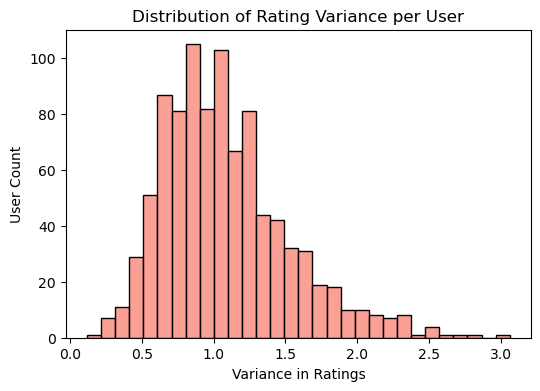

In [17]:
# Compute mean & variance of ratings per user
user_var = data.groupby("user_id")["rating"].agg(["mean", "var", "count"]).reset_index()
user_var = user_var[user_var["count"] >= 20]  # filter: only users with >=20 ratings to avoid noise

# Top 10 most polarizing (highest variance)
polarizing_users = user_var.sort_values("var", ascending=False).head(10)

# Top 10 most consistent (lowest variance)
consistent_users = user_var.sort_values("var", ascending=True).head(10)

print("Most Polarizing Users:\n", polarizing_users)
print("\nMost Consistent Users:\n", consistent_users)

# Visualize distribution of user variance
plt.figure(figsize=(6,4))
sns.histplot(user_var["var"], bins=30, kde=False, color="salmon")
plt.title("Distribution of Rating Variance per User")
plt.xlabel("Variance in Ratings")
plt.ylabel("User Count")
plt.show()

Polarizing users → people who rate both 1’s and 5’s (high variance).

Consistent users → people who stick to similar ratings (low variance).

Distribution plot → shows how common each type of user is.

#### Mean vs Variance per User

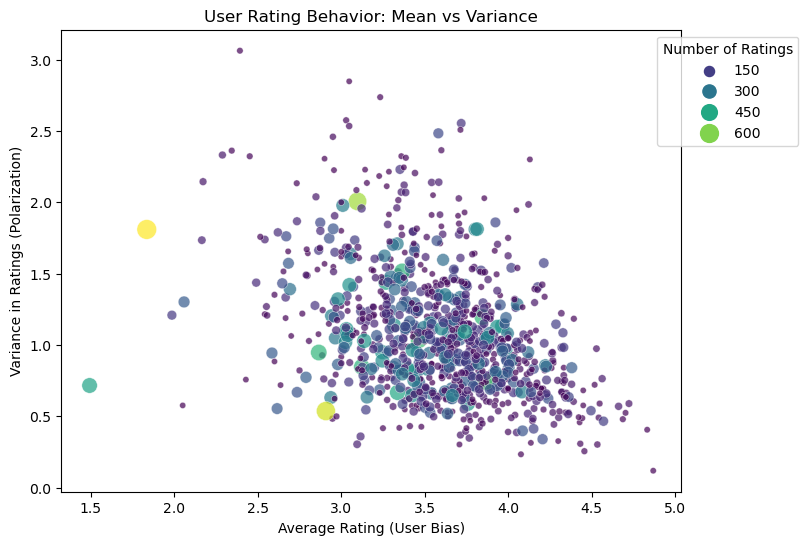

In [18]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="mean", 
    y="var", 
    size="count", 
    hue="count", 
    data=user_var, 
    palette="viridis", 
    alpha=0.7, 
    sizes=(20, 200)
)
plt.title("User Rating Behavior: Mean vs Variance")
plt.xlabel("Average Rating (User Bias)")
plt.ylabel("Variance in Ratings (Polarization)")
plt.legend(title="Number of Ratings", loc="upper right", bbox_to_anchor=(1.2,1))
plt.show()

X-axis (mean) → whether a user is generous (~4–5) or harsh (~1–2).

Y-axis (variance) → whether a user is consistent (low var) or polarizing (high var).

Point size/color → number of ratings by that user (so you can filter out one-offs).

So you’ll see clusters like:

Generous but consistent → always giving 4s.

Harsh but consistent → always giving 2s.

Polarizing → jumping between 1s and 5s.

🧑‍🤝‍🧑 User Behavior & Demographics Insights
1. User Bias (Average Rating per User)

Most users tend to cluster around an average rating of 3–4 stars, but we also see clear groups of “generous” users (avg >4) and “strict” users (avg <2.5). This highlights rating bias at the individual level.

2. Gender-Based Ratings

On average, male and female users rate movies similarly, with only minor differences. The distribution suggests that gender is not a strong differentiator in overall generosity of ratings.

3. Age Groups

Younger users (18–24) tend to be slightly more critical, while older groups (45+) give more generous ratings on average. This could indicate differences in expectations across age demographics.

4. Occupation

Some occupations appear to be “generous raters” (e.g., educators, retired users) while others (e.g., students, programmers) skew lower. This suggests lifestyle or cultural factors may influence how people score movies.

5. Polarizing Users

Looking at variance in ratings:

Polarizing users → rate both 1s and 5s, showing extreme swings.

Consistent users → stick to similar ratings across movies.

6. Mean vs Variance Scatterplot

The scatterplot of average rating vs variance reveals:

Generous but consistent users → always rate high (~4 stars, low variance).

Harsh but consistent users → stick to lower scores (~2 stars, low variance).

Polarizers → scatter across the plot, rating both high and low depending on the movie.